## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные объединили в датасет.

Предстоит решить бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## Исследование структуры данных

Начнем с исследования структуры данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Признак **date** не является типом datetime64, нужно преобразовать его.

In [4]:
data['date'] = pd.to_datetime(data['date'])
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Убедимся в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируем данные по признаку группы и определим первую и последнюю дату наблюдения для каждой из групп. 

In [5]:
piv_time = data.groupby('group')['date'].agg(['min', 'max'])
piv_time

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


A/B-тест проводился cо 2 по 24 января 2021 года.

## Сравнение некоторых показателей

In [6]:
# количество посещений сайта в группах А и B
visits_a = data[data['group']=='A']['user_id'].count()
visits_b = data[data['group']=='B']['user_id'].count()
print('Число посещений сайта группой А: {}\nЧисло посещений сайта группой B: {}'.format(visits_a, visits_b))

Число посещений сайта группой А: 147202
Число посещений сайта группой B: 147276


In [7]:
# суммарное количество покупок в группах А и B?
purchase_a = data[data['group']=='A']['purchase'].sum()
purchase_b = data[data['group']=='B']['purchase'].sum()
print('Суммарное количество покупок в группе А: {}\nСуммарное количество покупок в группе B: {}'.format(purchase_a, purchase_b))

Суммарное количество покупок в группе А: 17723
Суммарное количество покупок в группе B: 17514


In [8]:
# сумма всех покупок в группах А и B
total_a = data[data['group']=='A']['price'].sum()
total_b = data[data['group']=='B']['price'].sum()
print('Сумма всех покупок в группе А: {} млн.руб\nСуммарное количество покупок в группе B: {} млн. руб.'.format(total_a/1e6, total_b/1e6))

Сумма всех покупок в группе А: 1436.26 млн.руб
Суммарное количество покупок в группе B: 1554.1 млн. руб.


Группы максимально похожи по некоторых признакам.

Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей?

In [9]:
set_a = set(data[data['group']=='A']['user_id'])
set_b = set(data[data['group']=='B']['user_id'])
user_intersection = set_a.intersection(set_b)
print(len(user_intersection))

1895


1895 пользователей оказались в обеих группах. Необходимо исключить их.

## **Исключим пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

In [10]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## Первичный анализ А/В-тестирования

Сгруппируем данные по признаку группы. В каждой группе рассчитаем следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

Чему на этот раз равно количество посещений сайта в группах А и B?

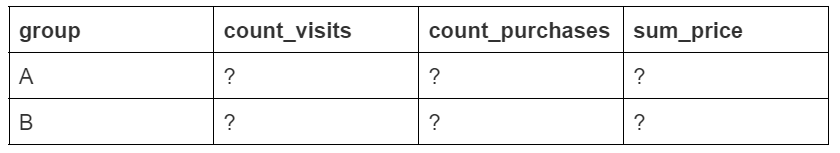

In [11]:
gr_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits',
                        'purchase': 'count_purchases',
                        'price': 'sum_price'})

gr_data.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


**Вывод:**

В обеих группах сопоставимое количество посещений. В группе "В" всего лишь на 74 посещения больше. Количество покупок тоже сопоставимо. Мы можем с уверенностью говорить о сбалансированности выборок.

Добавим в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

In [12]:
gr_data['conversion'] = round(gr_data['count_purchases']/gr_data['count_visits']*100, 2)
gr_data['mean_check'] = round(gr_data['sum_price']/gr_data['count_purchases'])
gr_data

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


**Вывод:**

Пока что можно отметить, что конверсия в группе А больше, хотя и средняя сумма покупки меньше. Если смотреть с точки зрения повышения среднего чека и выручки, то выгоднее вариант В.

## Сравнение А и В по покупательской способности

Давайте сравним варианты по покупательской способности туров. Для этого построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [13]:
purchasing_power = updated_data.groupby(['group', 'price'])['purchase'].sum().unstack()
purchasing_power

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируем полученную сводную таблицу с помощью тепловой карты с аннотацией.

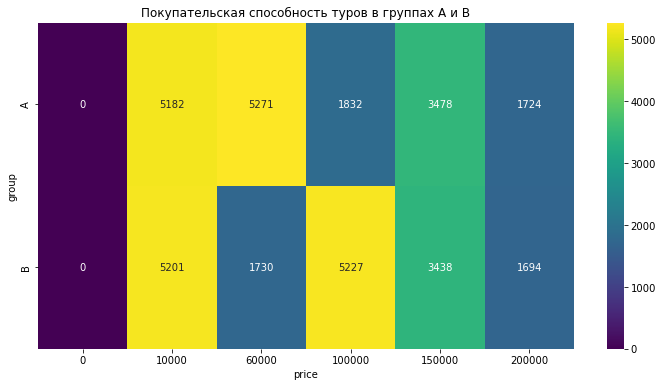

In [14]:
fig = plt.figure(figsize=(12, 6))
ax = sns.heatmap(purchasing_power, fmt='.0f', annot=True, cmap='viridis')
ax.set_title('Покупательская способность туров в группах А и В');

**Вывод:**

По тепловой карте можно заметить, что в группе А значительно больше людей приобретают туры за 60 тыс. руб., в то время как в группе В значительное количество купленных туров за 100 тыс. рублей. Далее - туры за 150 и 200 тыс. рублей, покупают примерно одинаково в обеих группах. То же самое и по дешёвым турам за 10 тыс. в Санкт-Петербург, их в обеих группах одинаково покупают. 

## Стабилизация кумулятивных метрик во времени

Необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируем данные по дате и группе тестирования. В каждой группе вычислим количество посещений страницы, количество покупок и сумму покупок. 

In [15]:
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits',
                        'purchase': 'count_purchases',
                        'price': 'sum_price'})
daily_data['daily_conv'] = daily_data['count_purchases']/daily_data['count_visits']*100
daily_data['daily_mean_check'] = daily_data['sum_price']/daily_data['count_purchases']
daily_data.head()

,date,group,count_visits,count_purchases,sum_price,daily_conv,daily_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


In [16]:
# конверсия по группам 03 января 2021 года:
daily_data[daily_data['date']=='2021-01-03'][['group', 'daily_conv']].round(2)

,group,daily_conv
2,A,11.34
3,B,11.39


In [17]:
# средний чек по группам 03 января 2021 года:
daily_data[daily_data['date']=='2021-01-03'][['group', 'daily_mean_check']].round()

,group,daily_mean_check
2,A,82888.0
3,B,87480.0


Добавим в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Вычислим кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей.

In [18]:
# кумулятивное количество посещений страницы
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()

# кумулятивное количество покупок
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()

# кумулятивная сумма покупок
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()

In [19]:
# кумулятивная конверсия
daily_data['cum_conv'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits']*100

# кумулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

In [20]:
daily_data.head(4)

,date,group,count_visits,count_purchases,sum_price,daily_conv,daily_mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conv,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427


In [21]:
# Какая кумулятивная конверсия была в группе B на 20 января?
round(daily_data[(daily_data['date']=='2021-01-20') & (daily_data['group']=='B')]['cum_conv'], 2)

37    11.9
Name: cum_conv, dtype: float64

In [22]:
# Какой кумулятивный средний чек был в группе А на 12 января 2021 года?
round(daily_data[(daily_data['date']=='2021-01-12') & (daily_data['group']=='A')]['cum_mean_check'])

20    81492.0
Name: cum_mean_check, dtype: float64

Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

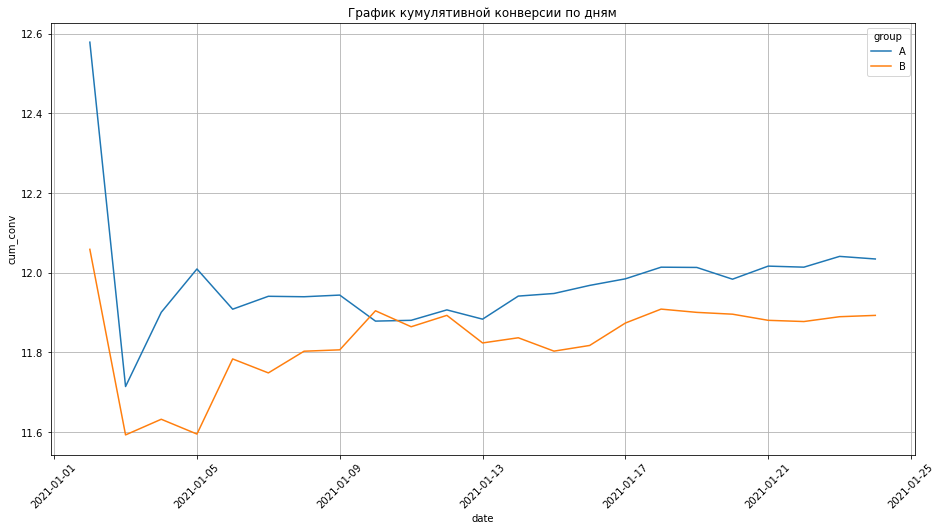

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conv', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid();

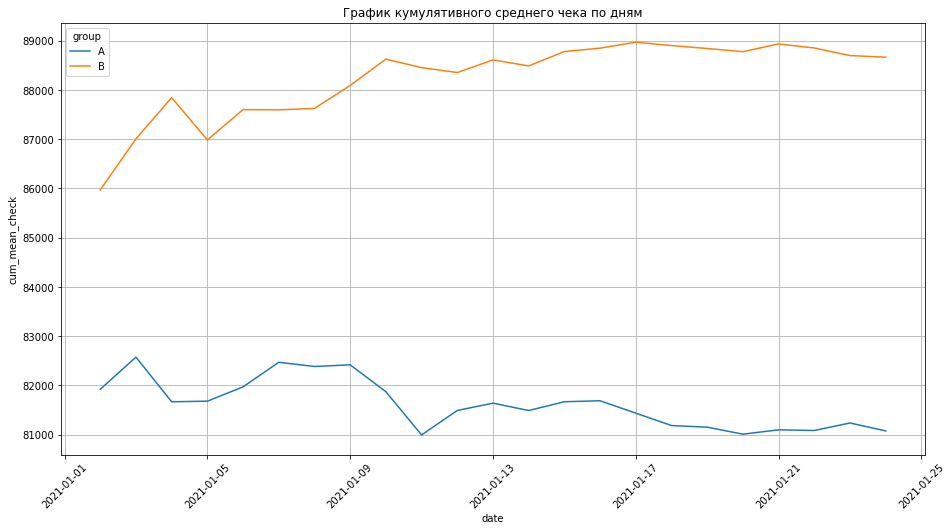

In [24]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid();

**Вывод:**

В начале данные подвержены сильному колебанию, но со временем они выравниваются. Это касается обоих графиков: кумулятивной конвенции и кумулятивного среднего чека - значит, А/В-тест можно назвать совершённым. На графиках прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую. 
По графику кумулятивной конверсии видно, что конверсия в группе А выше. По графику кумулятивного среднего чека: кумулятивный средний чек в группе В оказался выше.


## Проверка статистической значимости разницы между метриками в группах

Начнем с конверсии.

Будем использовать z-тестирование, так как сравниваем две группы, и объектов в выборке больше 30.

Проводим тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислим p-value теста для конверсий в группах А и B. Сравним полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [25]:
# количество наблюдений и успехов (т.е. покупки)
converted_piv = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

converted_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [26]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'

alpha = 0.05

In [27]:
# вычисляем значение p-value  z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'],
    alternative='larger')

print('p-value: ', round(p_value, 2))

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


**Вывод:**

Конверсия в группах А и В статистически незначима. С точки зрения конверсии эффективность обоих вариантов посадочной страницы сайта одинакова.

Убедимся в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используем $z_{крит}$ в своих расчетах.

In [28]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [29]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    ''' возвращаем кортеж из округлённых границ интервала'''
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [30]:
conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group']=='A']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group']=='B']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='B']['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


Проинтерпретируем построенные доверительные интервалы для конверсий в группах.

In [31]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
   
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [32]:
# размеры выборок групп А и B
n = [updated_data[updated_data['group']=='A']['user_id'].count(), updated_data[updated_data['group']=='B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group']=='A']['purchase'].mean(), updated_data[updated_data['group']=='B']['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


**Вывод:**

В подтверждение результатов Z-теста для пропорций лёг результат доверительного интервала: статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике, так как интервал "перешагивает" через ноль.

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

Применим тест Шапиро-Уилка для проверки гипотезы о нормальности распределения ежедневного среднего чека - оценивает выборку данных и определяет, насколько вероятно, что данные удут получены из распределения Гаусса.

In [33]:
H0 = 'Распределение нормально в обеих группах'
H1 = 'Распределение отлично от нормального'

alpha = 0.05

In [34]:
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group']=='A']['daily_mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group']=='B']['daily_mean_check'])

print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))


# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print('Отвергаем нулевую гипотезу!')
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение нормально в обеих группах


## Сравнение вариантов дизайна страницы по метрике "средний чек"

Проведём тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислим p-value теста для ежедневного среднего чека в группах А и B. Сравним полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [35]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'

alpha = 0.05

In [36]:
 # Так как распределение нормально, то применим Т-тестирование
results = ttest_ind(
    a=daily_data[daily_data['group']=='A']['daily_mean_check'],
    b=daily_data[daily_data['group']=='B']['daily_mean_check'], 
    alternative='less'
)

print('p-value:', round(results.pvalue, 2))

 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу!")
    print("Принимаем альтернативную гипотезу. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу!
Принимаем альтернативную гипотезу. H1: Ежедневный средний чек в группе А меньше, чем в группе B


**Вывод:**

Действительно, существует статистическая разница между ежедневными средними чеками в группах А и В: в группе В он выше. С точки зрения метрики среднего чека, дизайн сайта варианта В эффективнее.

## 95%-ый доверительный интервал

Построим 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используем  $t_{крит}$ в своих расчетах.

In [37]:
daily_data.head()

,date,group,count_visits,count_purchases,sum_price,daily_conv,daily_mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conv,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


In [38]:
def t_proportions_conf_interval(n, x_mean, x_std, gamma=0.95): 
    
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t крит.
    eps = t_crit * x_std / n**0.5 # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    
    return round(lower_bound), round(upper_bound)



In [39]:
conf_interval_a = t_proportions_conf_interval(
n=daily_data[daily_data['group']=='A']['group'].count(),
x_mean=daily_data[daily_data['group']=='A']['daily_mean_check'].mean(),
x_std=daily_data[daily_data['group']=='A']['daily_mean_check'].std()
)

conf_interval_b = t_proportions_conf_interval(
n=daily_data[daily_data['group']=='B']['group'].count(),
x_mean=daily_data[daily_data['group']=='B']['daily_mean_check'].mean(),
x_std=daily_data[daily_data['group']=='B']['daily_mean_check'].std()
)

print('Доверительный интервал для среднего чека в группе А: {}'.format(conf_interval_a))
print('Доверительный интервал для среднего чека в группе B: {}'.format(conf_interval_b))

Доверительный интервал для среднего чека в группе А: (79630, 82308)
Доверительный интервал для среднего чека в группе B: (87626, 89526)


Проинтерпретируем построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [40]:
def t_diff_proportions_conf_interval(n, x_mean, x_std, gamma=0.95):   
    
    k = max(n) - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t крит.
    eps = t_crit * ((x_std[1] / n[1]**0.5) - (x_std[0] / n[0]**0.5))  #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    
    return lower_bound, upper_bound

In [41]:
n = [daily_data[daily_data['group']=='A']['group'].count(), daily_data[daily_data['group']=='B']['group'].count()]
x_mean=[daily_data[daily_data['group']=='A']['daily_mean_check'].mean(), daily_data[daily_data['group']=='B']['daily_mean_check'].mean()]
x_std=[daily_data[daily_data['group']=='A']['daily_mean_check'].std(), daily_data[daily_data['group']=='B']['daily_mean_check'].std()]
diff_inverval = t_diff_proportions_conf_interval(n, x_mean, x_std)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (array([81358.32913837, 88964.75955298]), array([80580.24105964, 88186.67147424]))


## **Oбщий вывод по результатам A/B-теста**

Подводя итоги с помощью статистического анализа и доверительных интервалов можно увидеть, что с точки зрения конверсии вариант сайта А не хуже варианта В, но вот с точки зрения среднего чека вариант В оказался эффективнее - тому подтверждение Т-тест, показавший, что В-версия приносит больший доход, и доверительный интервал среднего чека группы В больше, чем в группе А (что подтверждено пересечением - обе границы пересечения положительны).